In [130]:
import numpy as np
import tensorflow as tf

import keras

from tensorflow.keras import layers, Model
from tensorflow.keras import datasets

from tensorflow.keras.losses import MeanSquaredError, KLDivergence, binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

# Data Load and Data Split

In [131]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print("Train set shape:    ", x_train.shape)
print("Train labels shape: ", y_train.shape)
print("Test set shape:     ", x_test.shape)
print("Test labels shape:  ", y_test.shape)

Train set shape:     (50000, 32, 32, 3)
Train labels shape:  (50000, 1)
Test set shape:      (10000, 32, 32, 3)
Test labels shape:   (10000, 1)


## before normalization

In [132]:
x_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

## after normalization

In [133]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [134]:
latent_dim = 1024
image_shape = x_train[0].shape
print(image_shape)

(32, 32, 3)


In [135]:
mse_loss = MeanSquaredError()
kl_loss = KLDivergence()

In [136]:
class VAE(keras.Model):
    def __init__(self, latent_dim, image_shape, beta):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.image_shape = image_shape
        self.beta = beta

        # encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=image_shape, name="Encoder_Input_Layer"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_1"),
            layers.Conv2D(32, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_2"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_2"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_3"),
            layers.Conv2D(64, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_4"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_4"),

            # layers.BatchNormalization(name="Encoder_BatchNorm_5"),
            layers.Conv2D(128, 3, strides=2, activation='relu', padding='same', name="Encoder_Conv2D_6"),
            # layers.BatchNormalization(name="Encoder_BatchNorm_6"),

            layers.Flatten(name="Encoder_Flatten"),
            # layers.Dense(512,  name="Encoder_Dense_1"),
        ])
        
        # reparameterization/sampling layer 
        self.z_mean = layers.Dense(latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(latent_dim, name="z_log_var")
        
        # decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(8*8*64, activation='relu'),
            layers.Reshape((8, 8, 64)),
            layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
        ])
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
     
    # Build the encoder
    def encode(self, data):
        x = self.encoder(data)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        return z_mean, z_log_var
    
    # Build the reparameterization/sampling layer 
    def reparameterization(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        z =  z_mean + tf.exp(0.5 * z_log_var) * epsilon
        return z
    
    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar
    
    def decode(self, data):
        return self.decoder(data)
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def recon_loss(self, data, reconstruction):
        return tf.reduce_mean(binary_crossentropy(data, reconstruction))

    def kl_divergence(self, Z_logvar, Z_mu):
        kl = -0.5 * tf.reduce_mean(1 + Z_logvar - Z_mu**2 - tf.math.exp(Z_logvar))
        return self.beta * kl

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encode(data)
            z = self.reparameterization(z_mean, z_log_var)      
            reconstruction = self.decode(z)

            reconstruction_loss = self.recon_loss(data, reconstruction)
            kl_loss = self.kl_divergence(z_log_var, z_mean)
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [137]:
vae = VAE(latent_dim,  image_shape, 0.2)

In [138]:
vae.compile(optimizer=keras.optimizers.Adam())
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1)
history = vae.fit(x_train, epochs=10, batch_size=512, callbacks=[early_stopping])

# print(history.history)

Epoch 1/10
 7/98 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - kl_loss: 2.5425e-04 - loss: 0.6930 - reconstruction_loss: 0.6928

W0000 00:00:1712760263.185092      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712760263.188242      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712760263.189439      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - kl_loss: 6.8481e-04 - loss: 0.6870 - reconstruction_loss: 0.6862 - total_loss: 0.6725
Epoch 2/10
 5/98 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - kl_loss: 0.0067 - loss: 0.6281 - reconstruction_loss: 0.6214

W0000 00:00:1712760268.668610      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 0.0072 - loss: 0.6243 - reconstruction_loss: 0.6171 - total_loss: 0.6203
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 0.0097 - loss: 0.6139 - reconstruction_loss: 0.6042 - total_loss: 0.6119
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 0.0113 - loss: 0.6078 - reconstruction_loss: 0.5966 - total_loss: 0.6071
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 0.0120 - loss: 0.6057 - reconstruction_loss: 0.5937 - total_loss: 0.6052
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 0.0124 - loss: 0.6040 - reconstruction_loss: 0.5916 - total_loss: 0.6039
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 0.0126 - loss: 0.6029 - reconstruction_loss: 0.5903 - total_loss: 0.6024
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 0.0125 - loss: 0.6006 - reconstruction_loss: 0.5881 - total_loss: 0.5996
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - kl_loss: 0.01

In [139]:
def generate_images_from_latent_vectors(vae, num_images_to_generate):
    # Generate random latent vectors
    random_latent_vectors = np.random.normal(size=(num_images_to_generate, latent_dim))

    # Decode the latent vectors to generate images
    generated_images = vae.decoder.predict(random_latent_vectors)

    return generated_images

# Generate images from random latent vectors
generated_images = generate_images_from_latent_vectors(vae, 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


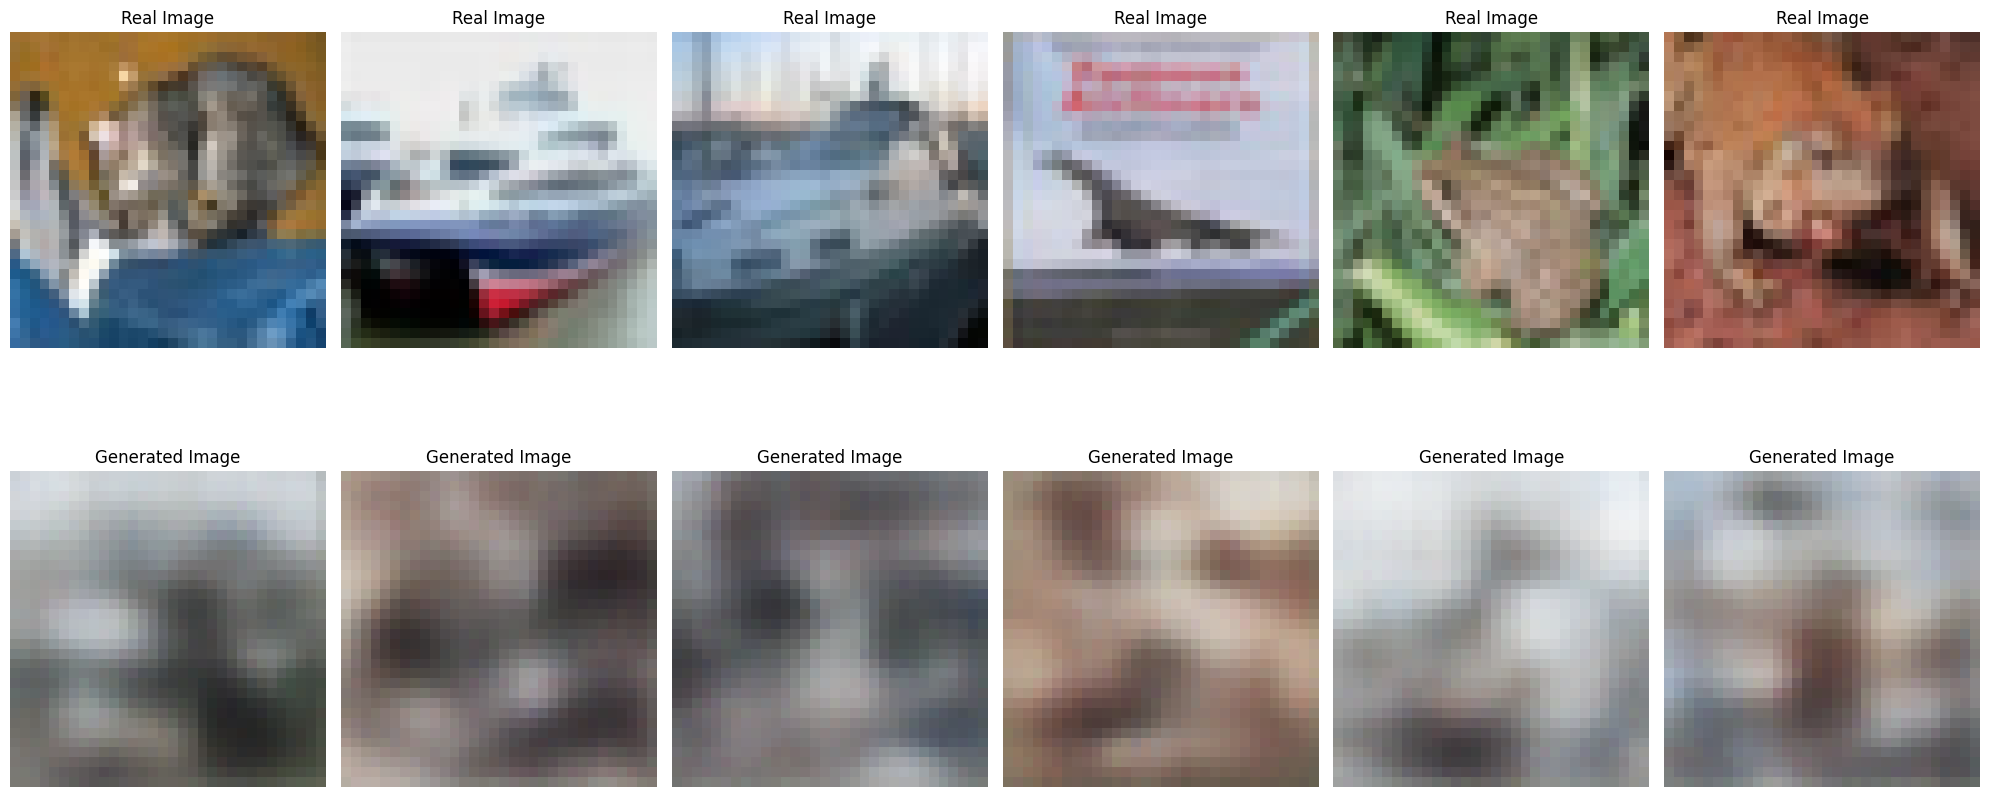

In [140]:
def plot_real_and_generated_images(real_images, generated_images, num_images_to_generate):
    plt.figure(figsize=(20, 10))

    # Plot real images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, i + 1)
        plt.imshow(real_images[i])
        plt.title('Real Image')
        plt.axis('off')

    # Plot generated images
    for i in range(num_images_to_generate):
        plt.subplot(2, num_images_to_generate, num_images_to_generate + i + 1)
        plt.imshow(generated_images[i])
        plt.title('Generated Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Plot real and generated images side by side vertically
plot_real_and_generated_images(x_test[:6], generated_images, 6)


In [141]:


class Classifier(keras.Model):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.dense1 = layers.Dense(128, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Instantiate the VAE and Classifier
latent_dim = 32
image_shape = (32, 32, 3)  # Example shape, replace it with your actual image shape
num_classes = 10  # Example number of classes, replace it with your actual number of classes
vae = VAE(latent_dim, image_shape, beta=1.0)
classifier = Classifier(num_classes)

# Create a new model that combines VAE encoder output and classifier
combined_model_input = keras.Input(shape=image_shape, name="Combined_Input_Layer")
vae_encoder_output = vae.encoder(combined_model_input)
classifier_output = classifier(vae_encoder_output)
combined_model = keras.Model(inputs=combined_model_input, outputs=classifier_output)

# Freeze the encoder weights
for layer in vae.encoder.layers:
    layer.trainable = False




In [142]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
# x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# Compile the combined model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the combined model
history  = combined_model.fit(x_train, y_train, epochs=10, batch_size=512, validation_data=(x_test, y_test))

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2373 - loss: 2.1248

W0000 00:00:1712760297.209469      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2379 - loss: 2.1236 - val_accuracy: 0.3601 - val_loss: 1.8490
Epoch 2/10
20/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3611 - loss: 1.8437

W0000 00:00:1712760298.598942      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3714 - loss: 1.8141 - val_accuracy: 0.3885 - val_loss: 1.7395
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4018 - loss: 1.7202 - val_accuracy: 0.4198 - val_loss: 1.6672
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4215 - loss: 1.6552 - val_accuracy: 0.4367 - val_loss: 1.6157
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4393 - loss: 1.6017 - val_accuracy: 0.4489 - val_loss: 1.5750
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4538 - loss: 1.5663 - val_accuracy: 0.4519 - val_loss: 1.5485
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4617 - loss: 1.5358 - val_accuracy: 0.4649 - val_loss: 1.5181
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4739 - loss: 1.5007 - val_accuracy: 0.4679 - val_loss: 1.4988
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4841 - loss: 1.4733 - val_accuracy: 0.4611 - val_loss: 1.4971
Epo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


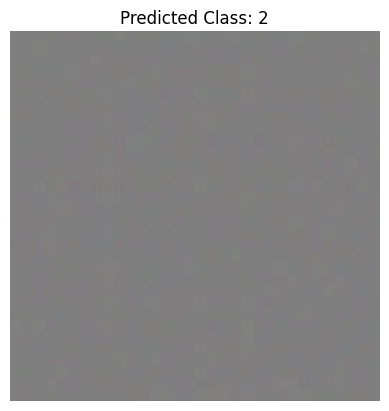

In [148]:


def generate_latent_vector(latent_dim):
    return np.random.normal(size=(1, latent_dim))


# Load the trained classifier model
classifier = combined_model.layers[-1]

# Generate a latent vector
latent_vector = generate_latent_vector(latent_dim)

# Decode the latent vector to generate an image
generated_image = vae.decoder.predict(latent_vector)

# Make a prediction using the trained classifier
encoded_image = vae.encoder.predict(generated_image)
prediction = np.argmax(classifier.predict(encoded_image))

# Reshape the generated image to match the original image shape
generated_image_reshaped = generated_image.reshape(image_shape)

plt.imshow(generated_image_reshaped)
plt.title(f"Predicted Class: {prediction}")
plt.axis('off')
plt.show()


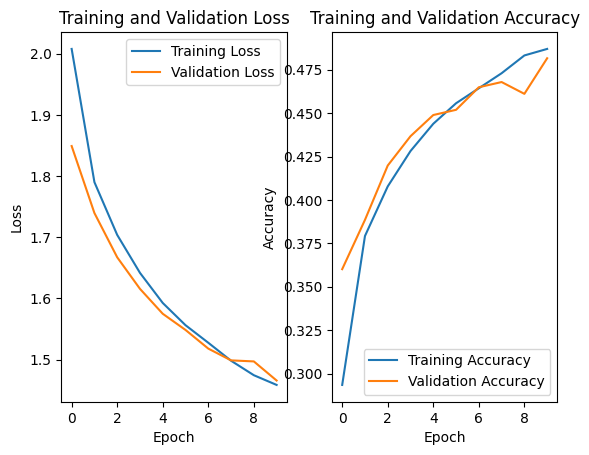

In [149]:
# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()